## Introduction

Deep Learning frameworks enable Machine Learning (ML) practitioners to build and train ML models. However, the process of deploying ML models in production to serve predictions (also known as inferences) in real time is more complex. It requires that ML practitioners build a scalable and performant model server, which can host these models and handle inference requests at scale. Model Server for Apache MXNet (MMS), was developed to address this hurdle. MMS is a highly scalable, production ready inference server. MMS was designed in a ML/DL framework agnostic way to host models trained in any ML/DL framework.

In this blog post, we will showcase how anyone could use Model Server for Apache MXNet (MMS) to host their model trained using any Machine Learning/Deep Learning (ML/DL) framework or tool kit in production. We chose Amazon Sagemaker service for production hosting - this PaaS solution does a lot of heavy lifting to provide infrastructure and allows users to focus on their use cases. We will be using “Bring your own Inference code with Amazon Sagemaker hosting”  approach, where users could bring their models together with all necessary dependencies, libraries, frameworks and other components compiled inside of a single custom-built docker container and host it on Sagemaker. 

To showcase the true “ML/DL framework agnostic architecture” of MMS, we chose to launch a model trained with “PaddlePaddle” framework into production.

The overall picture of steps involved to take a model trained on any ML/DL framework to Amazon Sagemaker using MMS BYO container looks as follows:

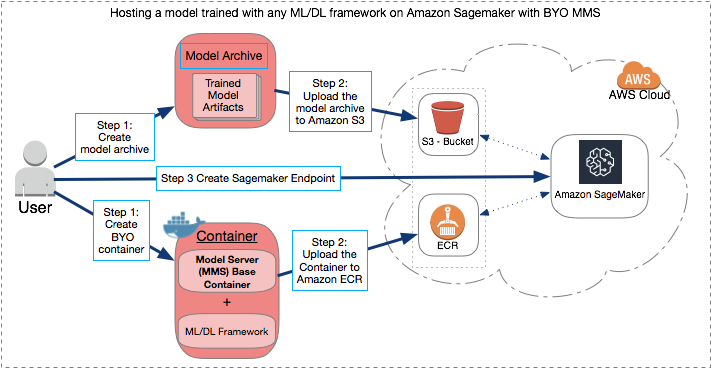

As shown in the picture above, in order to bring your own ML/DL framework to Amazon Sagemaker using MMS Bring Your Own (BYO) container, we need two main components

1. **Model artifacts/Model Archive**: These are all the artifacts required to run your model on a given host. This contains the following:
  1. **Model files**, which are usually symbols and weights. These are the artifacts of training a model.
  2. **Custom Service File**: This file contains the entry-point which gets called every time when inference request is received and served by MMS. This file generally contains the logic to initialize the model in a particular ML/DL framework, preprocess the incoming request, run inference in a particular ML/DL framework and post-process logic which takes the data coming out of framework's inference method and converts it to end-user consumable data.
  3. **MANIFEST File**: This is the interface between custom service file and the MMS. This file is generated by running a tool that comes as part of MMS distribution, called “model-archiver”.
2. **Container artifact**: To load and run a model written in a custom DL framework on Sagemaker, you need to bring a container that will be run on Sagemaker service. In this document we will show how to use MMS base container and extend it to support custom DL frameworks and other model dependencies. The MMS base container is a docker container that comes with a highly scalable and performant model-server which is readily launchable onto Sagemaker service.
In the following sections, we will see each of the above components in detail.

## Preparing a Model
MMS container is completely ML/DL framework agnostic. Users can write models in a ML/DL framework of their choice and bring it to Sagemaker with MMS BYO container to get the features of scalability and performance. In this blogpost, we chose to showcase this by bringing in a model written for PaddlePaddle framework. Lets look at how to prepare a PaddlePaddle model in the following sections. The model artifact is readily available at <*TODO: Update this with the S3 link with model.tar.gz*>.

### Preparing Model Artifacts
We are going to use [Understand Sentiment](https://github.com/PaddlePaddle/book/tree/develop/06.understand_sentiment) example that is available and published in examples section of PaddlePaddle repository. First of all we need to create a model. In order to do that we followed instructions provided in [PaddlePaddle/book](https://github.com/PaddlePaddle/book) repository: downloaded  container and ran training by the notebook that is provided as part of the example. We used “Stacked Bidirectional LSTM” network for our training and trained the model for 100 epochs. At the end of this training exercise, we get the following list of trained model artifacts.

```bash
!ls
embedding_0.w_0    fc_2.w_0    fc_5.w_0    learning_rate_0    lstm_3.b_0    moment_10    moment_18    moment_25    moment_32    moment_8
embedding_1.w_0    fc_2.w_1    fc_5.w_1    learning_rate_1    lstm_3.w_0    moment_11    moment_19    moment_26    moment_33    moment_9
fc_0.b_0    fc_3.b_0    fc_6.b_0    lstm_0.b_0    lstm_4.b_0    moment_12    moment_2    moment_27    moment_34
fc_0.w_0    fc_3.w_0    fc_6.w_0    lstm_0.w_0    lstm_4.w_0    moment_13    moment_20    moment_28    moment_35
fc_1.b_0    fc_3.w_1    fc_6.w_1    lstm_1.b_0    lstm_5.b_0    moment_14    moment_21    moment_29    moment_4
fc_1.w_0    fc_4.b_0    fc_7.b_0    lstm_1.w_0    lstm_5.w_0    moment_15    moment_22    moment_3    moment_5
fc_1.w_1    fc_4.w_0    fc_7.w_0    lstm_2.b_0    moment_0    moment_16    moment_23    moment_30    moment_6
fc_2.b_0    fc_5.b_0    fc_7.w_1    lstm_2.w_0    moment_1    moment_17    moment_24    moment_31    moment_7
```

These artifacts constitute a PaddlePaddle model. We copy these artifacts from within training container to localhost so that it will be easier to begin preparation of the model for production hosting. To learn more on how to copy files from inside a docker container to location outside of it please refer to [Docker CLI](https://docs.docker.com/engine/reference/commandline/cp/).

### Writing Custom Service Code
We now have model files required to host the model in production. We can now define a custom service file which knows how to use these files and also knows how to “preprocess” the raw request coming into the server and how to “postprocess” the responses coming out of the PaddlePaddle framework's “infer” method. For this, we modified the notebook example written to test the trained model *<TODO: supply link to what was the source of the example notebook>*. Let's look at some code. 

We created a custom service file called “paddle_sentiment_analysis.py”. Here, we first define a class called “PaddleSentimentAnalysis” which contains methods to initialize the model and also defines pre-processing, post-processing and inference methods. Refer [Custom Service Code](https://github.com/awslabs/mxnet-model-server/blob/master/docs/custom_service.md) document to learn how to write your custom-service code. The skeleton of this file is as follows:

```bash
$ cat paddle_sentiment_analysis.py
```
```python

from __future__ import print_function
import paddle
import paddle.fluid as fluid
import paddle.dataset as dataset
from functools import partial

  
class PaddleSentimentAnalysis(object):
    def __init__(self):
    ...

    def initialize(self, context):
    """
    This method is used to initialize the network and read other artifacts.
    """
    ...
    
    def preprocess(self, data):
    """
    This method is used to convert the string requests coming from client 
    into tensors. 
    """
    ...

    def inference(self, input):
    """
    This method runs the tensors created in preprocess method through the 
    DL framework's infer method.
    """
    ...

    def postprocess(self, output, data):
    """
    Here the values returned from the inference method is converted to a 
    human understandable response.
    """
    ...
    

_service = PaddleSentimentAnalysis()


def handle(data, context):
"""
This method is the entrypoint \"handler\" method that is used by MMS.
Any request coming in for this model will be sent to this method.
"""
    if not _service.initialized:
        _service.initialize(context)

    if data is None:
        return None

    pre = _service.preprocess(data)
    inf = _service.inference(pre)
    ret = _service.postprocess(inf, data)
    return ret
```

### Note about Permissions
Running this notebook requires permissions in addition to the normal **SageMakerFullAccess** permissions. This is because we'll creating new repositories in Amazon ECR. The easiest way to add these permissions is simply to add the managed policy **AmazonEC2ContainerRegistryFullAccess** to the role that you used to start your notebook instance. There's no need to restart your notebook instance when you do this, the new permissions will be available immediately.

### Creating Model artifact file to be hosted on sagemaker
In order to load this model onto Sagemaker platform with MMS BYO container, we need to do the following:

1. Create a MANIFEST file, which is used by MMS as a model's metadata to load and run the model.
2. Add the above custom-service file and the trained model-artifacts, along with the MANIFEST file, to a .tar.gz file.

Let's use “model-archiver” tool, to accomplish the above points. Before we use the tool to create a “.tar.gz” artifact, we need to collect all the model artifacts, including the custom-service-file mentioned above, into a separate folder. For ease of getting started, we have uploaded all the model artifacts onto an [S3 bucket](https://s3.amazonaws.com/model-server/blog_artifacts/PaddlePaddle_blog/sentiment.tar.gz). Lets run the following commands to get this artifact onto your host:

In [ ]:
!(curl https://s3.amazonaws.com/model-server/blog_artifacts/PaddlePaddle_blog/artifacts.tgz | tar zxvf -) 2>/dev/null

In [ ]:
!ls -R artifacts/sentiment

Now that we have the model artifacts, let's convert this to a model artifact that can be hosted on Sagemaker. 

### Prerequisites
Before we proceed with preparing a Sagemaker model-artifact and endpoint, we need the following:
#### Software packages and tools
1. pip
1. Docker
1. Model-archiver tool
1. Sagemaker SDK
1. Boto3 

#### AWS user account with following permissions
We will need AWS account user with permissions to 
1. Create roles (or access to an already existing Sagemaker role)
2. Create Sagemaker Endpoint
3. Create an ECR repository and upload a container to the repository
4. Create an S3 bucket and upload an artifact to S3 bucket

We are now ready to create a sagemaker model artifact. For this, we use the "model-archiver" tool to create a Sagemaker model artifact. 

In [ ]:
!pip install -U mxnet-model-server

In [ ]:
!model-archiver -f --model-name paddle_sentiment \
--handler paddle_sentiment_analysis:handle \
--model-path artifacts/sentiment --export-path . --archive-format tgz

The above command would create an model artifact called `paddle_sentiment.tar.gz`, which we will use to host our endpoint. Let's verify if this model artifact is created.

In [ ]:
!ls

Next let's take a look at how to build a container with it and bring it into Sagemaker.

### Building your own BYO container with MMS

In this section, we build our own MMS based container which can be brought onto Sagemaker (also known as BYO Container).

To help with this process, every released version of MMS comes with a corresponding MMS base container, hosted on [DockerHub](https://hub.docker.com/r/awsdeeplearningteam/mxnet-model-server/tags) which can be hosted on the Sagemaker platform.

For this example, we will use container tagged *awsdeeplearningteam/mxnet-model-server:base_cpu_py3.6*. To host the model created in the above section, we need to install “PaddlePaddle” and “numpy” packages in the container. This can be done by creating a Dockerfile which extends from the base MMS image and installs the above python packages. Here is how its content should look like:

In [ ]:
!cat artifacts/Dockerfile.paddle.mms

Now that we have Dockerfile that describes our BYO container let's build it:

In [ ]:
!cd artifacts && docker build -t paddle-mms -f Dockerfile.paddle.mms .

## Creating Sagemaker endpoint with PaddlePaddle model
Before we go on and create a Sagemaker endpoint for our model, we need to do some preparations:

### Upload the Sagemaker model artifact to a S3 bucket
Upload the model archive **sentiment.tar.gz** created above to a S3 bucket. Here we uploaded it to the S3 bucket called paddle_paddle. 

In [ ]:
import boto3, os, uuid

s3 = boto3.resource('s3')
s3_bucket_name = 'paddle-sentiment-model-'+ str(uuid.uuid1())
local_model_artifact = s3_model_artifact = 'paddle_sentiment.tar.gz'

Now lets create a bucket called **paddle-sentiment-model**. Here is where we will copy the model, **paddle_sentiment.tar.gz**, that we had created above.

In [ ]:
import sagemaker
from sagemaker import get_execution_role
import boto3
from botocore.exceptions import ClientError
import json

sess = sagemaker.Session()
account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name

s3.create_bucket(Bucket=s3_bucket_name,  CreateBucketConfiguration={
    'LocationConstraint': region})

In [ ]:
s3.meta.client.upload_file(local_model_artifact, s3_bucket_name, s3_model_artifact)

We now have **paddle_sentiment.tar.gz** on S3 in our account. Now let's look at having the container that we built on ECR, so that we can go ahead and set up our Sagemaker Endpoint.

### Upload the container image to ECR
We had built an image called **paddle-mms** above. We need to upload this to a Amazon ECR in our account.

In [ ]:
%%sh

# The name of our algorithm
algorithm_name=paddle-mms

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
# specifically setting to us-east-1 since during the pre-release period, we support only that region.
region=${region:-us-east-1}

echo "region is " $region

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

echo $fullname
# If the repository doesn't exist in ECR, create it.

aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR
# with the full name.

docker tag ${algorithm_name}:latest ${fullname}

docker push ${fullname}

This pushes the "paddle-mms" container to Amazon ECR in your account.

## Creating Sagemaker Endpoint
Now that the model and container artifacts are uploaded onto S3 and ECR respectively, we can go ahead and create Sagemaker endpoint. To do that we need to complete following steps


#### Sagemaker role

Before we go onto create an Sagemaker endpoint, we need to setup an IAM role which has **AmazonSageMakerFullAccess** and **AmazonS3FullAccess** and **AmazonEC2ContainerRegistryFullAccess** policy attached to it. 

In [ ]:
import sagemaker
from sagemaker import get_execution_role
import boto3
from botocore.exceptions import ClientError
import json

sess = sagemaker.Session()
account = sess.boto_session.client('sts').get_caller_identity()['Account']
region = sess.boto_session.region_name
# NOTE: If you already have a sagemaker execution role created with above attached policies, use it instead of calling get_execution_role()
sm_role = get_execution_role()
inference_image = '{}.dkr.ecr.{}.amazonaws.com/paddle-mms:latest'.format(account, region)
s3_url = 's3://{}/{}'.format(s3_bucket_name, s3_model_artifact)

We created the role required to launch our Sagemaker endpoint above. Now let's use the Sagemaker SDK to launch an endpoint.

In [ ]:
inf_handler = None

In [ ]:
from sagemaker.model import Model

endpoint = 'PaddleSentiment'
paddle_model = Model(model_data=s3_url, image=inference_image, role=sm_role)
try:
    inf_handler = paddle_model.deploy(1, 'ml.m4.xlarge', endpoint_name=endpoint)
except ClientError as e:
    if 'ValidationException' == e.response['Error']['Code']:
        print("The endpoint \"{}\"already exists".format(endpoint))
        pass
    else:
        raise

This creats an sagemaker endpoint using the model artifact "paddle_sentiment.tar.gz".

### Testing the endpoint
Let's test the endpoint. To do this, we will send a movie review to the endpoint "paddle-sentiment".

In [ ]:
from sagemaker.predictor import json_serializer, csv_serializer, json_deserializer, RealTimePredictor
predictor = RealTimePredictor(endpoint=endpoint, sagemaker_session=sess)

message = "This is an amazing movie."
print(predictor.predict(message).decode('utf-8'))

You would get a response showing that the review was positive.
### Delete Endpoint
After testing your endpoint, you could delete the endpoint you created as follows.

In [ ]:
sess.delete_endpoint(endpoint)

### Conclusion
We have just shown how to build and host PaddlePaddle model on Sagemaker using MMS BYO container. This flow can be reused with minor modifications in order to build BYO containers serving inference traffic on Sagemaker endpoints with MMS for models built using many ML/DL frameworks, not just PaddlePaddle.